# Problem Statement:

**Objective:** To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Key Questions:**
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

#### This can also be found on [my Git repository](https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-jul20-94Sip)

In [1]:

import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data and conduct EDA

In [2]:
from pathlib import Path
data_folder = Path("c:/Users/natha/Documents/PGAIML/Credit Card Customer Segmentation Case/")

file_to_open = data_folder / "cc_data.xlsx"

# Convert path to the right format for the current operating system
correct_path = Path(file_to_open)

print(correct_path)
cust = pd.read_excel(correct_path)
cust.head(10)

c:\Users\natha\Documents\PGAIML\Credit Card Customer Segmentation Case\cc_data.xlsx


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [3]:
# need to drop the Sl_No column as that appears to be a type of identity value carried over from source system
cust.drop(['Sl_No'],axis=1, inplace=True)


In [4]:
# now, lets look and see if we have any explicit null value and the datatypes of each column
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


#### Observation: we do not appear to have any null values, and none of the datatypes are of string/object, so we don't need to worry about odd characters such as ? or other forms of data corruption

In [5]:
# now, want to undertand the cutomer key before we decide to drop it
cust.nunique()

Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

#### Observation: Customer Key has 655 unique values, which means that there are some duplicates in this field

In [6]:
dupes = cust[cust.duplicated(['Customer Key'], keep=False)]

dupes

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,47437,100000,6,0,12,3
48,37252,6000,4,0,2,8
104,97935,17000,2,1,2,10
332,47437,17000,7,3,1,0
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2
411,50706,44000,4,5,0,2
432,37252,59000,6,2,1,2
541,50706,60000,7,5,2,2
632,97935,187000,7,1,7,0


#### Observation: from the above, 'Customer Key' can be duplicated as they can how max of 2 cards. Going to keep as the data is different, and this coud be of small value to the model since the data for each row is different enough they could be in different clusters.

In [7]:
cust.describe()


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


#### Observtions: 
1. initial inspection, the Avg_Credit_Limit field looks to be very dispersed (have outliers) - lets investigate this along with the others.
2. The other fields do not appear to have outliers.

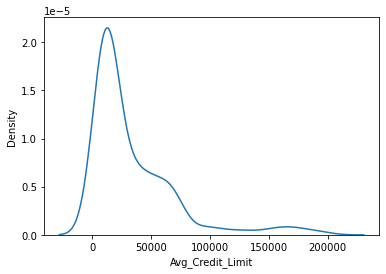

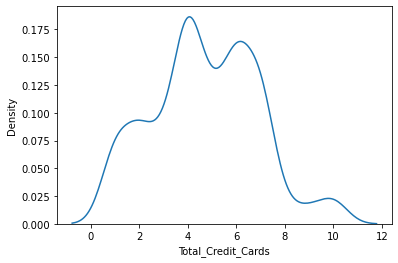

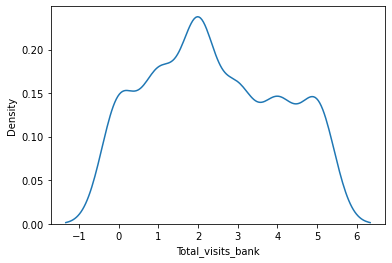

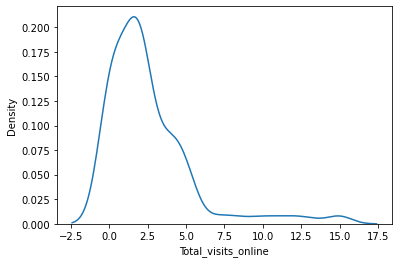

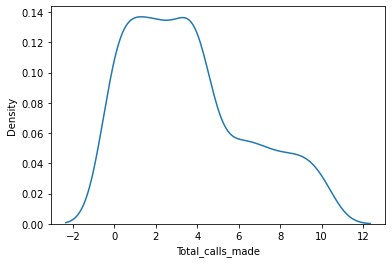

In [8]:
import seaborn as sns

for i in cust.columns[cust.columns!='Customer Key']:
    sns.kdeplot(cust[i])
    plt.show()

#### Observations:
1. Avg Credit Limit (and Total_visits_online) is positively skewed, as should be expected since majority of people will have lower credit limits. This could indicate some correlation between these characteristics.
2. By inspection of various density curves, could see the possibility of 3-4 clusters.

In [9]:
from scipy.stats import zscore
# excluding 'Customer Id' field from the scaled dataset so it is NOT taken into account for clustering
custFeatures=cust.iloc[:,1:]

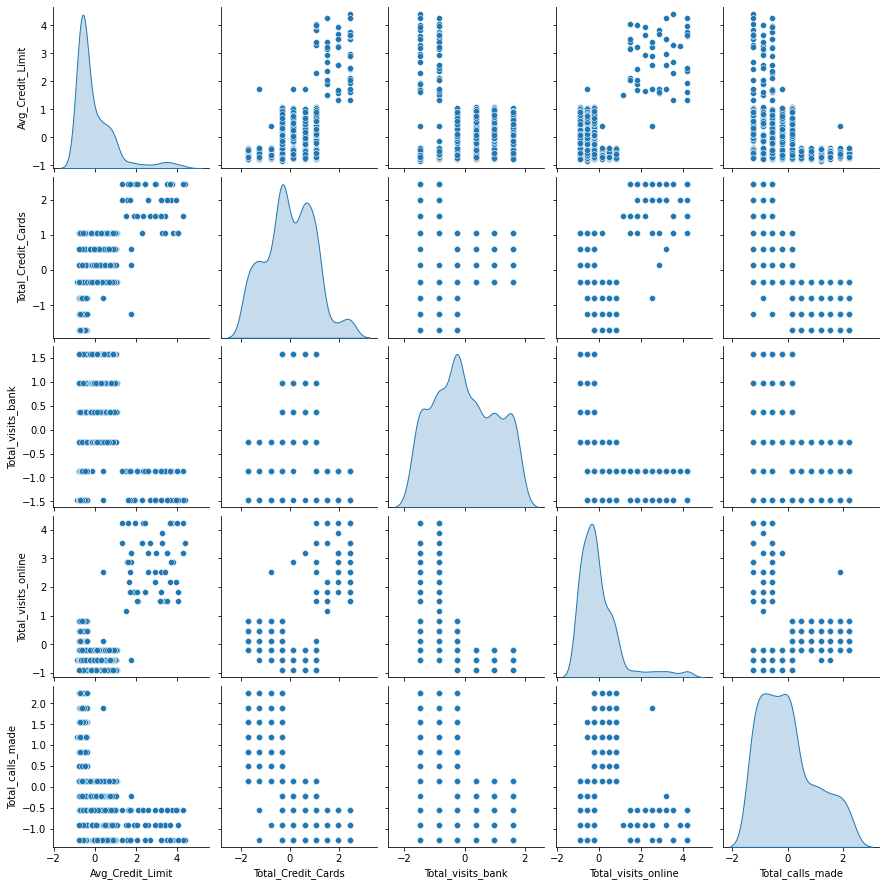

In [10]:
custFeaturesScaled=custFeatures.apply(zscore)
sns.pairplot(custFeaturesScaled,diag_kind='kde')

#### Observation: 
1. Total_Credit_Cards has some correlation with several other variables, such as Avg_Credit_Limit, and Total_Visits_Online
2. Avg_Credit_Limit: the more credit cards, the larger the credit limit.
3. Between several of the variables, such as Total_Calls_Made and Total_Visits_Online, you can see clusters of data
4. There is also a possible relationship between Total_Calls_Made and Avg_Credit_Limit - as calls made decreases, Avg_Credit_Limit goes up.

Will be interesting to see how these relationships show up in the clustering analysis...

## K-Means Clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

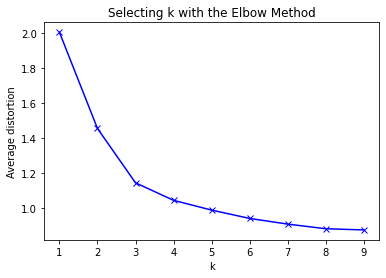

In [11]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(custFeaturesScaled)
    prediction=model.predict(custFeaturesScaled)
    meanDistortions.append(sum(np.min(cdist(custFeaturesScaled, model.cluster_centers_, 'euclidean'), axis=1)) / custFeaturesScaled.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

#### Observation:
1. Similar to discussed above, elobow method indicates 3 clusters, whereas I had originally hypothesized up to 4 clusters. 

### KMeans = 3 Analysis

In [72]:
#clean up dataset
def clean_groups_from_dataframe(df):
    """ Removes the GROUP column from a dataframe (inplace=True), if it exists

    Keyword Arguments:
    df -- the dataframe to clean
    """
    if 'GROUP' in df.columns:
        df.drop(['GROUP'],axis=1, inplace=True)

In [73]:
# starting with K = 3
threeK_model=KMeans(3)
threeK_model.fit(custFeaturesScaled)
three_predictions=threeK_model.predict(custFeaturesScaled)

#Append the prediction 
cust["GROUP"] = three_predictions
custFeaturesScaled["GROUP"] = three_predictions
print("Groups Assigned : \n")
cust.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,87073,100000,2,1,1,0,1
1,38414,50000,3,0,10,9,0
2,17341,50000,7,1,3,4,1
3,40496,30000,5,1,1,4,1
4,47437,100000,6,0,12,3,2


In [74]:
custClust = cust.groupby(['GROUP'])
custClust.mean()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,
0,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536
1,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


#### Observations:
1. Avg_Credit_Limit clearly stands out as a differentiating characteristic. 
2. Among the other characteristics, the means are not too close to each other, hence providing a clear explanation of difference between clusters.

### KMeans = 4 Analysis

In [15]:
#dropping GROUP column from scaled dataset so it does not influence heirarchical clustering
clean_groups_from_dataframe(custFeaturesScaled)

# now we will try with K=4
fourK_model=KMeans(4)
fourK_model.fit(custFeaturesScaled)
four_predictions=fourK_model.predict(custFeaturesScaled)

#Append the prediction 
cust["GROUP"] = four_predictions
custFeaturesScaled["GROUP"] = four_predictions
print("Groups Assigned : \n")
cust.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,87073,100000,2,1,1,0,0
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,0
3,40496,30000,5,1,1,4,0
4,47437,100000,6,0,12,3,2


In [16]:
custClust = cust.groupby(['GROUP'])
custClust.mean()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,
0,54071.849246,35904.522613,5.522613,2.477387,0.969849,2.075377
1,55257.135747,12167.420814,2.393665,0.927602,3.574661,6.923077
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000
3,55714.684211,31226.315789,5.478947,4.515789,1.010526,1.936842


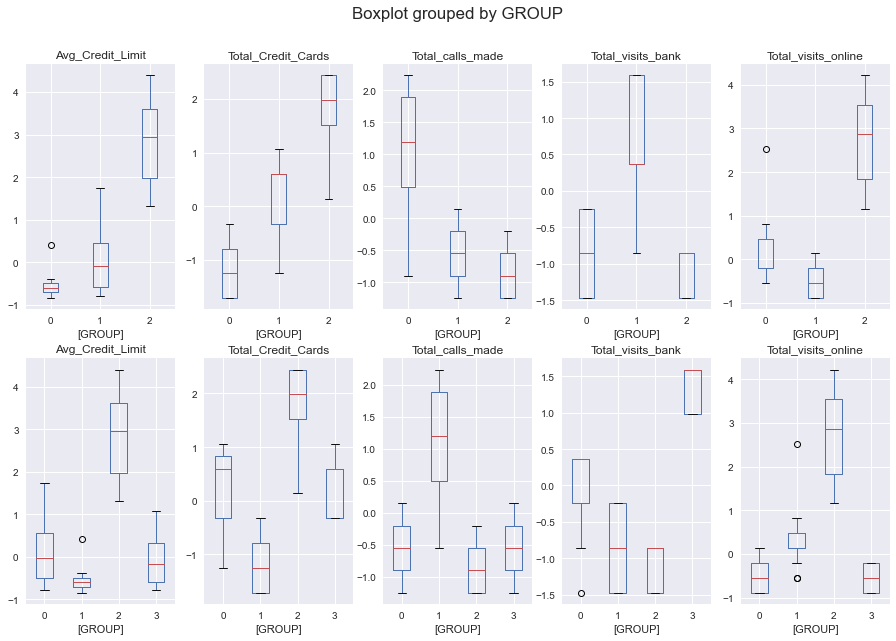

In [118]:
# After significant time, I have not been able to manipulate the plots and stylize them the way I wanted to. Namely, I could not get the axes title and Figure Title to show. Apparently, the DataFrame boxplot command overrides all those settings.

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,10))
fig.suptitle('Boxplot comparison for KMeans clustering', fontsize=24)
plt.style.use('seaborn-notebook')

#ax0 = top row
#ax1 = 2nd row

predictions = {3:three_predictions, 4: four_predictions}

for i in [3, 4]:
    clean_groups_from_dataframe(custFeaturesScaled)
    
    q, mod = divmod(i, 2)
    ax[q-1][0].set(title=f"KMeans={i} Clusters")
    custFeaturesScaled["GROUP"] = predictions[i]
    custFeaturesScaled.boxplot(by='GROUP', figsize=(15,10), ax=ax[q-1])
    
plt.show()

#### Observations:
1. 4 clusters does not create as easily discernible clusters - there is significant overlap across the features.
2. As the mean analysis showed earlier, the 3 cluster configuration demonstrates higher level of explainability.


### Silhouette Plots for KMeans Clustering options

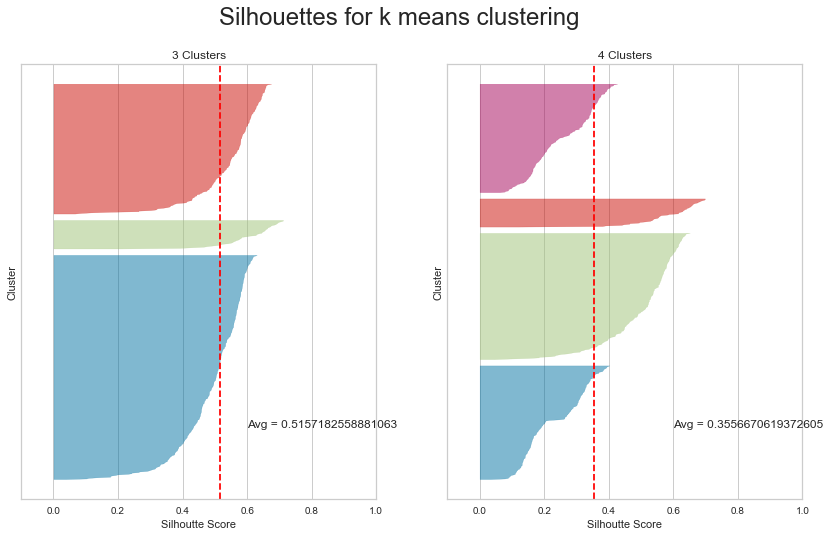

In [70]:
#using yellowbrick to make it easy to print silhouettes
from yellowbrick.cluster import SilhouetteVisualizer

clean_groups_from_dataframe(custFeaturesScaled)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
fig.suptitle('Silhouettes for k means clustering', fontsize=24)
fig.subplots_adjust(hspace = .5) #wspace=.001

models = {3: threeK_model, 4: fourK_model}

for i in [3, 4]:
    q, mod = divmod(i, 2)
    axi = ax[q-1] #[mod]
    visualizer = SilhouetteVisualizer(models[i], colors='yellowbrick', ax=axi)
    visualizer.fit(custFeaturesScaled)  
    axi.text(0.6, 100, f"Avg = {visualizer.silhouette_score_}")
    axi.set_xlim([-0.1, 1])
    axi.set_yticks([])  # Clear the yaxis labels / ticks
    axi.set(title=f"{i} Clusters", xlabel='Silhoutte Score', ylabel="Cluster")

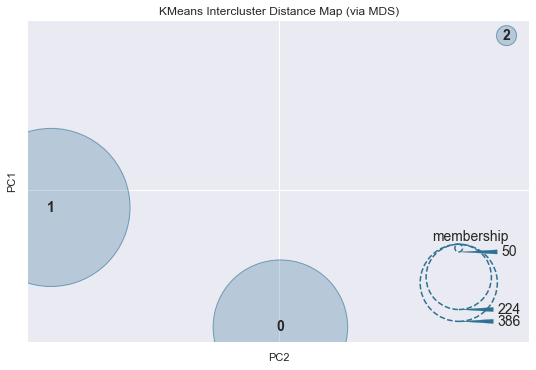

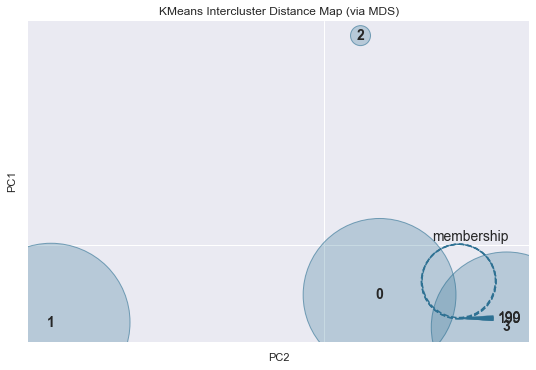

In [198]:
from yellowbrick.cluster import InterclusterDistance

clean_groups_from_dataframe(custFeaturesScaled)

models = {3: threeK_model, 4: fourK_model}

for i in [3, 4]:    
    map = InterclusterDistance(models[i], colors='yellowbrick', legend=True, legend_loc='lower right')
    map.fit(custFeaturesScaled)        # Fit the data to the visualizer
    map.show()        # Finalize and render the figure

#### Observations:
1. This visualization shows the separation of the clusters and the membership within the clusters.
2. Clearly, K=4 has overlap amongst the clusters

### Recommendation for K-Means Clustering:
1. The Silhoutte Plots show that the 3 clusters is the better option - all silhouttes are above the average score.
2. As we saw with the box plots, and with the groupby analysis, 2 of the clusters in the 4 cluster model are similarly shaped, and therefore, not very differentiable.
3. The clustering is not great though - the silhouttes of K=3 are not of similar width, which would be ideal.

Stay with 3 with clusters as they are more clearly delineated, and hence explainable to business users, as will be discussed in the Results section of this report.

## Heirarchical Clustering

In [23]:
#dropping GROUP column from scaled dataset so it does not influence heirarchical clustering
clean_groups_from_dataframe(custFeaturesScaled)

custFeaturesScaled.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593
6,1.740187,0.135694,-1.473731,2.861408,-0.553005
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326


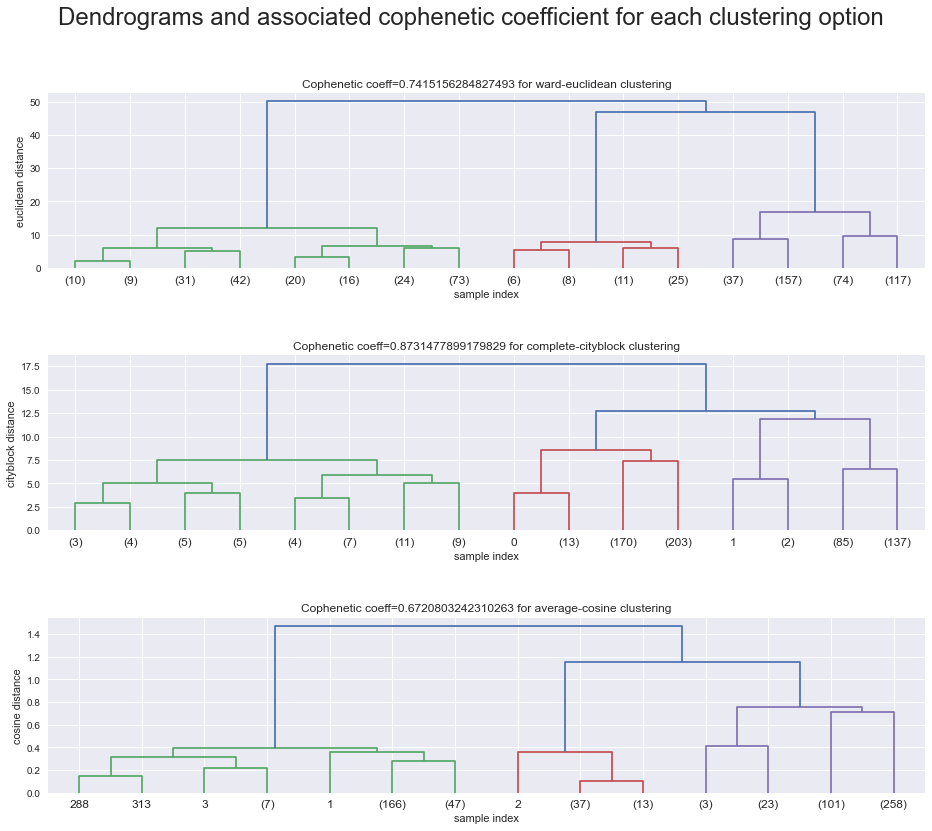

In [169]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points
import itertools
from sklearn.cluster import AgglomerativeClustering 
from matplotlib.gridspec import GridSpec

linkages = ['ward', 'complete', 'average']
metrics = ['euclidean', 'cityblock', 'cosine']

clean_groups_from_dataframe(custFeaturesScaled)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14,12))
fig.suptitle('Dendrograms and associated cophenetic coefficient for each clustering option', fontsize=24)
fig.subplots_adjust(hspace = .5) #wspace=.001

i=0

for (l,m) in zip(linkages,metrics):
    #print(l,m)
    
    #calculate linkage matrix and cophenetic coefficient
    Z = linkage(custFeaturesScaled.values, metric=m, method=l)
    c, coph_dists = cophenet(Z, pdist(custFeaturesScaled))

    #plot dendrogram
    subtitle = f"Cophenetic coeff={c} for {l}-{m} clustering"
    dendrogram(Z,no_plot=False,ax=axes[i],truncate_mode='level',p=3)
    axes[i].set_title(subtitle)
    axes[i].set(xlabel="sample index")
    axes[i].set(ylabel=f"{m} distance")
    i=i+1
    
plt.show()

#### Observations:
1. Complete-Cityblock has the highest cophenetic coefficient, which means the clusters are better defined.



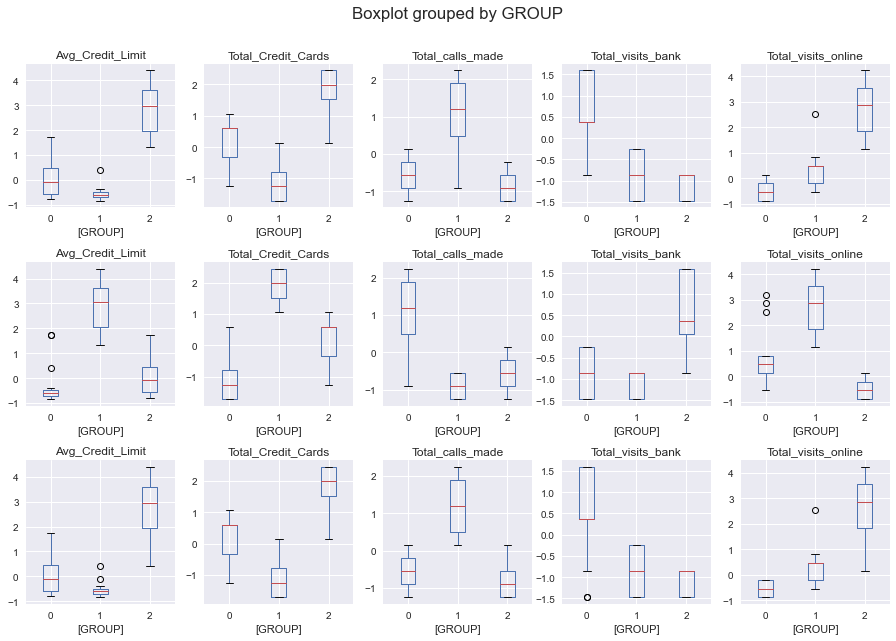

In [156]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
fig.suptitle('Boxplot comparison for Heirarchical clustering', fontsize=24)
#fig.subplots_adjust(hspace = .5) #wspace=.001
plt.style.use('seaborn-notebook')
plt.tight_layout(pad=5.0, w_pad=2.0, h_pad=2.0)

#ax0 = top row
#ax1 = 2nd row
i=0

for (l,m) in zip(linkages,metrics):
    #print(l,m)
    clean_groups_from_dataframe(custFeaturesScaled)

    h_model = AgglomerativeClustering(n_clusters=3, affinity=m,  linkage=l)
    h_model.fit_predict(custFeaturesScaled)
    
    col_label = f"{m}-{l}"
    #ax[i][0].set(title=col_label)

    # attach clustering labels to dataframe for visual inspection of clusters
    custFeaturesScaled['GROUP'] = h_model.labels_
    custFeaturesScaled.boxplot(by='GROUP', figsize=(15,10), ax=ax[i])
    i = i + 1

plt.show()

#### Observations:
1. 1st row (Ward-Euclidean boxplots): very similar to the 3rd row of boxplots (Average-Cosine). 
2. 2nd row (Complete-Cityblock): There is some overlap with calls_made and visits_bank but in general these look more discernible, and this model has the highest cophenetic coefficient.

### Let's look at the groupby analysis for Cityblock-Complete model

In [164]:
from sklearn.metrics import silhouette_score

clean_groups_from_dataframe(custFeaturesScaled)

if 'GROUP' in cust.columns:
        cust.drop(['GROUP'],axis=1, inplace=True)

h_model = AgglomerativeClustering(n_clusters=3, affinity='cityblock',  linkage='complete')
h_model.fit_predict(custFeaturesScaled)

cust["GROUP"] = h_model.labels_
heirClust = cust.groupby(['GROUP'])
heirClust.mean()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,
0,55099.435556,12977.777778,2.431111,0.920000,3.631111,6.844444
1,57075.645833,142750.000000,8.875000,0.625000,10.875000,1.020833
2,54925.966408,33713.178295,5.511628,3.485788,0.984496,2.005168


#### Let's look at the silhouette scores for each of the heirarchical clustering methods

In [166]:
#I'm including this here but I couldn't find anything that says to use Silhouette score to evaluate aglomerative clustering.

print("Silhouette Scores:")
for (l,m) in zip(linkages,metrics):
    clean_groups_from_dataframe(custFeaturesScaled)
    h_model = AgglomerativeClustering(n_clusters=3, affinity=m,  linkage=l)
    h_model.fit_predict(custFeaturesScaled)
    s_score = silhouette_score(custFeaturesScaled,h_model.labels_, metric=m)
    
    print(f"{l}-{m} model = {s_score}")

Silhouette Scores
ward-euclidean model = 0.5147639589977819
complete-cityblock model = 0.5449249468006867
average-cosine model = 0.6094704762721503


### Now, for comparison purposes, lets look at the groupby analysis (done earlier) for Kmeans=3

In [154]:
if 'GROUP' in cust.columns:
        cust.drop(['GROUP'],axis=1, inplace=True)

cust["GROUP"] = three_predictions

custClust = cust.groupby(['GROUP'])
custClust.mean()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,,
0,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536
1,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


### Analysis of KMeans=3 vs Agglomerative (Cityblock-Complete):
1. The Agglomerative method has a slighltly higher Silhouette Score (0.54) than the KMeans method (0.51)
2. The groupings are very similar in metrics.

## Overall Results & Discussion:
1. How many different segments of customers are there: The best clusters, using both KMeans and Heirarchical methods, appear to show __3__ distinct customer segments. The analysis for each of these methods using 3 clusters produced the highest technical scores, as discussed throughout this report. I therefore recommend for this bank to segment its customers into 3 "tiers".
2. How are these segments different from each other? The segments clearly show a difference in their Credit Limits and HOW they like to interact with the bank (online, phone, or in-person), as will be discussed in the following question.
3. What are your recommendations to the bank on how to better market to and service these customers?
    - You have a "high value" segment, which is the group that has a high credit limit. This group primarily banks online, as they don't visit the bank very much, and they don't call very much. This group will appreciate online banking capabilities, and not having to speak to a representative. Consider marketing thru online channels, developing functionality on your website so that they can do everything online, and perhaps test a chatbot, available thru the website.
    - On the opposite end of the spectrum, you have your tier that has a LOW credit limit. These individuals don't tend to bank in-person as they prefer using the phone, although they will use online, but not as their primary mode of interaction. Your representatives that answer the phone will need to market to this customer thru this channel.
    - Then you have your middle tier of customer, based on Credit Limit. They do very little banking online and their primary mode of interaction is to come to the bank. For this group, you will want marketing materials in the bank, and the representatives at the bank will need to be able to speak fluently about those campaigns.
